# Stonks 

Use tensorflow to build deep learning based time series forcasting models based on financial data.

Try out different neural network architectures, see which one works best for this task.

Keep track of the performance of all of the models.

Read the official Tensorflow time series forecasting [guide](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from iexfinance.refdata import get_symbols
from iexfinance.account import get_metadata
from iexfinance.stocks import get_historical_data, Stock

mpl.rcParams['figure.figsize'] = (16, 9)

In [2]:
iex_token = os.environ['IEX_TOKEN']
if iex_token is None:
    raise Exception("IEX_TOKEN should be set")
get_metadata()

,metadata
circuitBreaker,0
effectiveDate,None
messageLimit,5000000
messagesUsed,3270339
payAsYouGoEnabled,False
subscriptionTermType,annual
tierName,launch


### Dataset

Currently using iexcloud to access financial data.

[docs](https://iexcloud.io/docs/api/)

In [3]:
def create_df(csv_path, symbols, start, end, overwrite=False):
    if not overwrite and os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df['date'] = pd.to_datetime(df['date'])
        return df.set_index('date')
    else:
        df = get_historical_data(symbols, start, end)
        df.columns = df.columns.to_flat_index().map(lambda tup: f'{tup[0]}_{tup[1]}')
        df.to_csv(csv_path)
        return create_df(csv_path, symbols, start, end)

In [4]:
csv_path='stonks.csv'
symbols = ['TSLA', 'AAPL', 'GOOGL', 'MZN', 'WMT', 'MSFT', 'GE', 'F', 'TQQQ', 'QQQ', 'SPY', 'VOO', 'VTI', 'GLD', 'SLV', 'FNGU', 'XLF', 'EEM', 'SPXS', 'SPXL', 'VXX', 'UVXY', 'GDX', 'FXI', 'TZA', 'TNA', 'XLE', 'IWM', 'SQQQ', 'TLT', 'JETS']
start = datetime.datetime(2015, 9, 4)
end = datetime.datetime(2020, 9, 4)
df = create_df(csv_path, symbols, start, end, overwrite=False)

In [5]:
df.head()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_volume,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_volume,...,TLT_open,TLT_high,TLT_low,TLT_close,TLT_volume,JETS_open,JETS_high,JETS_low,JETS_close,JETS_volume
date,,,,,,,,,,,,,,,,,,,,,
2015-09-08,49.01,49.83,48.81,49.63,15691155,27.91,28.14,27.58,28.08,219374520,...,121.38,121.56,120.76,120.87,7049499,23.62,23.81,23.51,23.73,30786
2015-09-09,50.41,50.85,49.66,49.78,16953940,28.44,28.51,27.44,27.54,340043216,...,119.63,121.70,119.56,121.45,7441863,23.90,24.10,23.67,23.76,29996
2015-09-10,49.45,50.14,49.07,49.70,13545120,27.57,28.32,27.48,28.14,251571324,...,121.02,121.19,120.45,120.63,6789671,23.89,24.05,23.75,23.79,21841
2015-09-11,49.53,50.05,48.95,50.05,11754220,27.95,28.55,27.94,28.55,199661892,...,121.47,122.08,121.33,121.39,5890921,23.88,24.04,23.81,23.94,19883
2015-09-14,50.22,50.85,49.93,50.64,14454255,29.15,29.22,28.72,28.83,233453724,...,121.95,122.14,121.28,121.58,4221733,24.03,24.08,23.94,24.04,33511


In [6]:
df.tail()

,TSLA_open,TSLA_high,TSLA_low,TSLA_close,TSLA_volume,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_volume,...,TLT_open,TLT_high,TLT_low,TLT_close,TLT_volume,JETS_open,JETS_high,JETS_low,JETS_close,JETS_volume
date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,444.61,500.14,440.11,498.32,118374406,127.58,131.00,126.00,129.04,225702688,...,161.60,163.25,161.56,162.19,11388108,18.29,18.29,17.76,17.76,4984267
2020-09-01,502.14,502.49,470.51,475.05,90119419,132.76,134.80,130.53,134.18,152470142,...,161.76,164.07,161.18,163.86,10587634,17.56,18.12,17.39,17.77,4931572
2020-09-02,478.99,479.04,405.12,447.37,96176128,137.59,137.98,127.00,131.40,200118991,...,163.51,165.56,163.49,165.42,15167718,17.82,18.08,17.56,18.04,4253186
2020-09-03,407.23,431.80,402.00,407.00,87596086,126.91,128.84,120.50,120.88,257599640,...,165.75,167.24,165.44,165.89,16416624,18.16,18.74,17.69,18.00,8995202
2020-09-04,402.81,428.00,372.02,418.32,110321885,120.07,123.70,110.89,120.96,332607163,...,164.41,164.70,162.45,162.74,13780313,18.24,18.46,17.71,18.25,7907126


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TSLA_open,1259.0,7.417242e+01,6.075877e+01,28.46,4.587000e+01,59.35,6.903500e+01,5.021400e+02
TSLA_high,1259.0,7.582474e+01,6.300772e+01,30.99,4.648500e+01,60.20,7.000000e+01,5.024900e+02
TSLA_low,1259.0,7.246597e+01,5.836644e+01,28.21,4.511000e+01,57.91,6.784500e+01,4.705100e+02
TSLA_close,1259.0,7.424546e+01,6.098155e+01,28.73,4.592500e+01,59.08,6.902000e+01,4.983200e+02
TSLA_volume,1259.0,4.175065e+07,3.053411e+07,3551385.00,2.211148e+07,32358515.00,4.987730e+07,3.046938e+08
...,...,...,...,...,...,...,...,...
JETS_open,1259.0,2.724834e+01,4.947024e+00,11.83,2.410000e+01,29.07,3.096000e+01,3.473000e+01
JETS_high,1259.0,2.746265e+01,4.923247e+00,12.19,2.431500e+01,29.26,3.114000e+01,3.475000e+01
JETS_low,1259.0,2.699864e+01,5.025176e+00,11.25,2.383500e+01,28.85,3.074000e+01,3.427000e+01
JETS_close,1259.0,2.722529e+01,4.979738e+00,12.00,2.407500e+01,29.04,3.096000e+01,3.466000e+01


Check if any columns contain null entries, just get rid of them of them.

In [8]:
any(df.isnull().any(axis=0))

True

In [9]:
df = df.dropna(axis='columns')

In [10]:
any(df.isnull().any(axis=0))

False

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

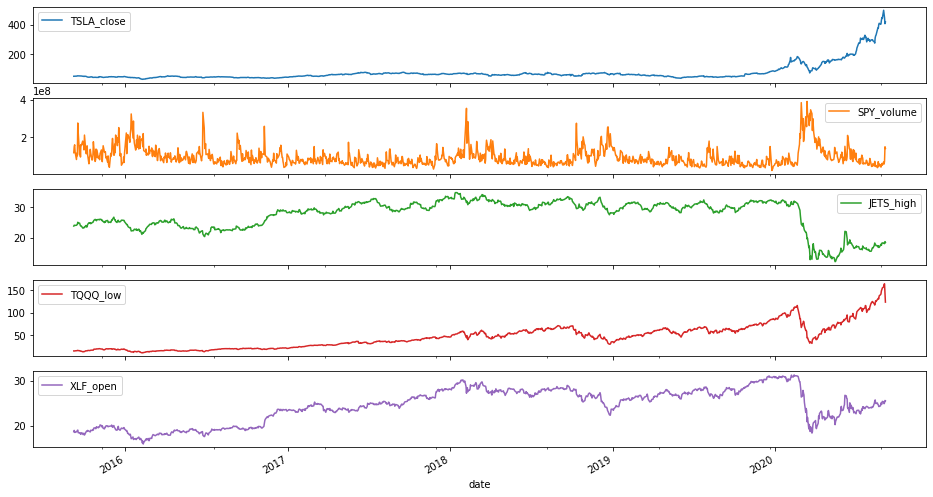

In [11]:
df[['TSLA_close', 'SPY_volume', 'JETS_high', 'TQQQ_low', 'XLF_open']].plot(subplots=True)

### Feature Engineering

#### Time

We want to account for seasonality in prices. We can map our `date` index feature datetimes into useable signals using sin and cos.

In [12]:
index_timestamp_seconds = np.array(df.index.map(datetime.datetime.timestamp))
index_timestamp_seconds

array([1.4416848e+09, 1.4417712e+09, 1.4418576e+09, ..., 1.5990192e+09,
       1.5991056e+09, 1.5991920e+09])

In [13]:
seconds_per_day = 24 * 60 * 60
seconds_per_year = 365.2425 * seconds_per_day
date_to_year_sin = np.sin(index_timestamp_seconds * (2 * np.pi / seconds_per_year))
date_to_year_cos = np.cos(index_timestamp_seconds * (2 * np.pi / seconds_per_year))

Text(0.5, 1.0, 'Time of year signal')

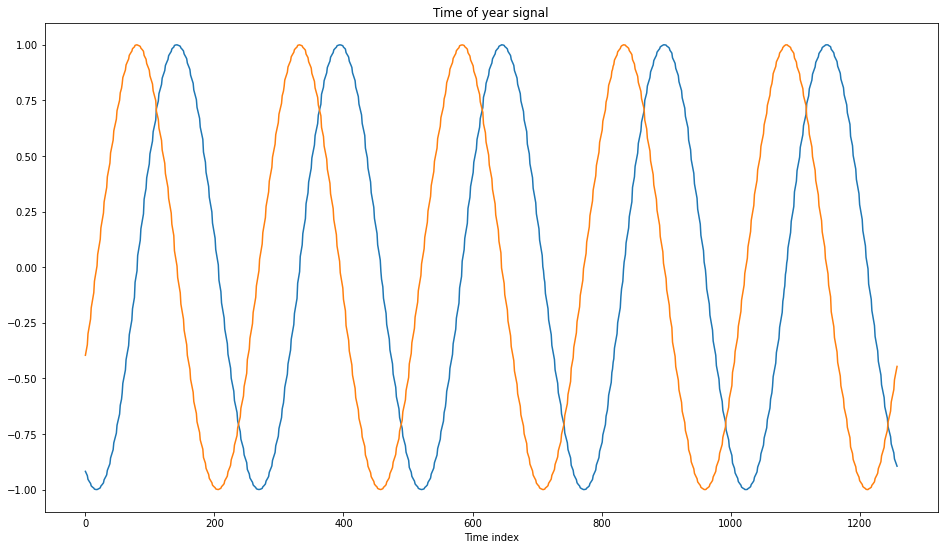

In [14]:
plt.plot(np.array(date_to_year_sin))
plt.plot(np.array(date_to_year_cos))
plt.xlabel('Time index')
plt.title('Time of year signal')

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

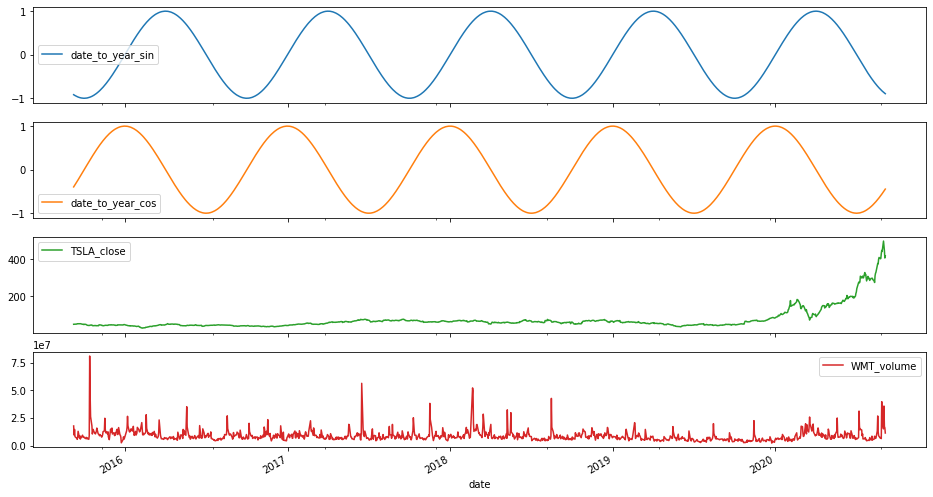

In [15]:
df['date_to_year_sin'] = date_to_year_sin
df['date_to_year_cos'] = date_to_year_cos
df[['date_to_year_sin', 'date_to_year_cos', 'TSLA_close', 'WMT_volume']].plot(subplots=True)

### Split the data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that we get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

We can use a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to visualize the probability density of the data at different values. Using a [seaborn violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html).

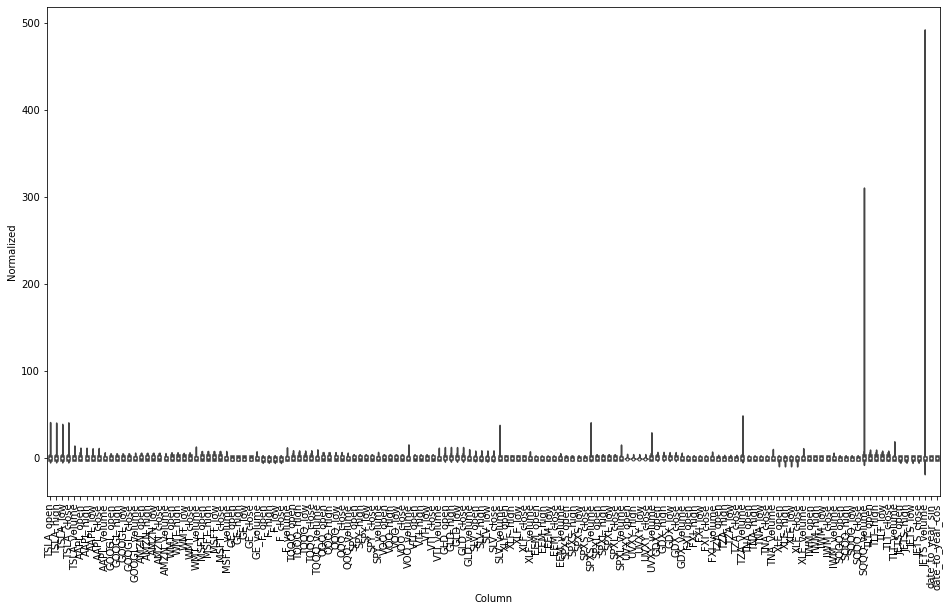

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

In [19]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='TSLA_close', max_subplots=3):
        inputs, labels = self.example
        plt.figure()
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [date]')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

### Single step models



In [20]:
label_columns = ['TSLA_close']

In [21]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=label_columns)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['TSLA_close']

In [22]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 147)
Labels shape (batch, time, features): (32, 1, 1)


#### baseline model

Need something simple to compare more complex models against

In [23]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [24]:
baseline = Baseline(label_index=column_indices[label_columns[0]])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8/8 [==============================] - 0s 630us/step - loss: 0.1406 - mean_absolute_error: 0.1758


In [25]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=label_columns)

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['TSLA_close']

In [26]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 147)
Output shape: (32, 1, 1)


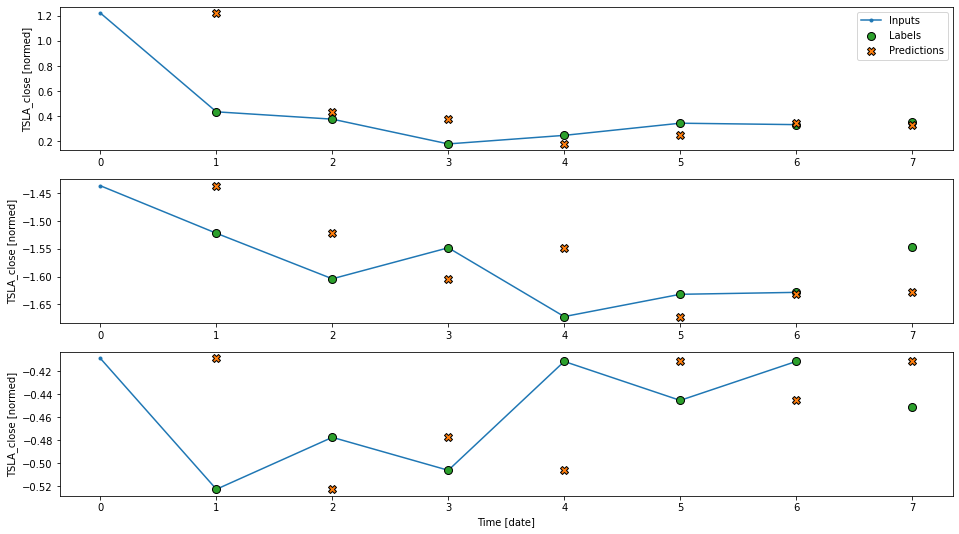

In [27]:
wide_window.plot(baseline)

In [28]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [29]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 147)
Output shape: (32, 1, 1)


In [30]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [31]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
28/28 [==============================] - 0s 6ms/step - loss: 2.3326 - mean_absolute_error: 1.2314 - val_loss: 14.0803 - val_mean_absolute_error: 2.8555
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.7093 - mean_absolute_error: 0.6729 - val_loss: 14.0004 - val_mean_absolute_error: 2.7980
Epoch 3/50
28/28 [==============================] - 0s 3ms/step - loss: 0.5409 - mean_absolute_error: 0.5970 - val_loss: 13.8837 - val_mean_absolute_error: 2.6854
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.4561 - mean_absolute_error: 0.5463 - val_loss: 12.9911 - val_mean_absolute_error: 2.5846
Epoch 5/50
28/28 [==============================] - 0s 3ms/step - loss: 0.3899 - mean_absolute_error: 0.5085 - val_loss: 11.8671 - val_mean_absolute_error: 2.4784
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.3377 - mean_absolute_error: 0.4736 - val_loss: 10.8902 - val_mean_absolute_error: 2.3820
Epoch 7/50
28/28 [====

8/8 [==============================] - 0s 653us/step - loss: 1.6039 - mean_absolute_error: 0.7641


In [32]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 7, 147)
Output shape: (32, 7, 1)


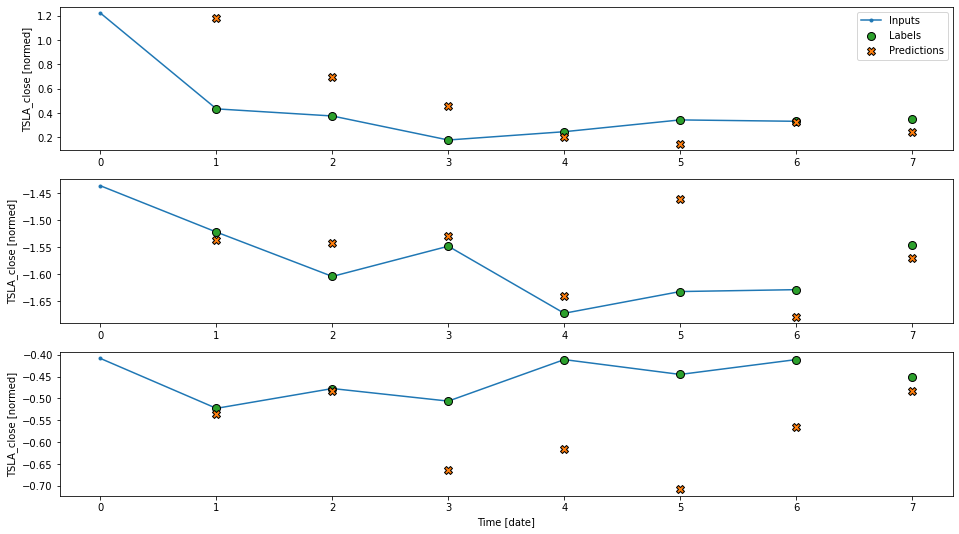

In [33]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights, and see the weight assigned to each input:

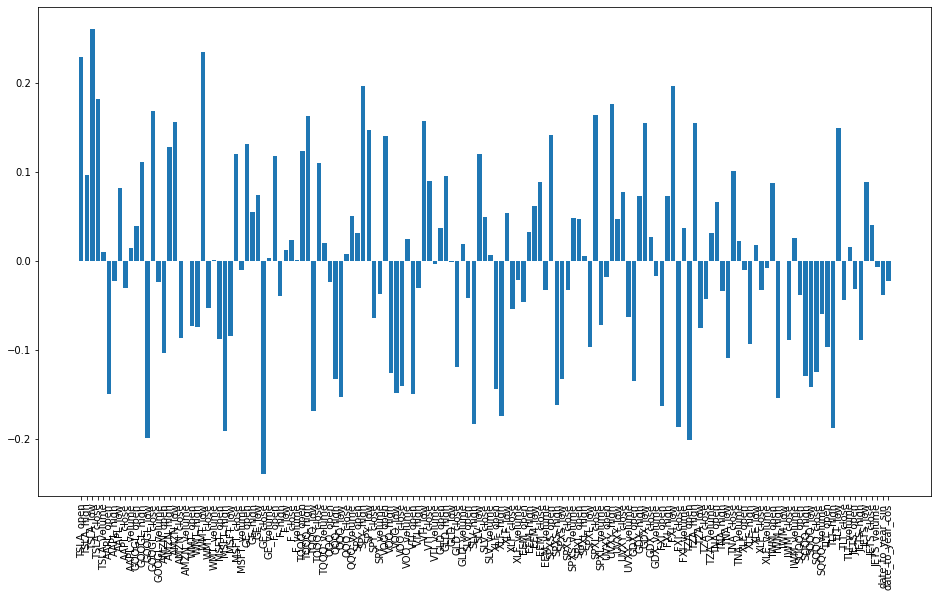

In [34]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `TSLA_close`. This is one of the risks of random initialization.

### Dense

In [35]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/50
28/28 [==============================] - 0s 8ms/step - loss: 0.2419 - mean_absolute_error: 0.3769 - val_loss: 3.5626 - val_mean_absolute_error: 1.3819
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0743 - mean_absolute_error: 0.2094 - val_loss: 2.2784 - val_mean_absolute_error: 1.0850
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0415 - mean_absolute_error: 0.1604 - val_loss: 2.0541 - val_mean_absolute_error: 0.9323
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0342 - mean_absolute_error: 0.1439 - val_loss: 1.7981 - val_mean_absolute_error: 0.9144
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0298 - mean_absolute_error: 0.1341 - val_loss: 1.5570 - val_mean_absolute_error: 0.8874
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0244 - mean_absolute_error: 0.1210 - val_loss: 1.6099 - val_mean_absolute_error: 0.8272
Epoch 7/50
28/28 [==========

#### Multi-step dense

In [36]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=label_columns)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['TSLA_close']

Text(0.5, 1.0, 'Given 3 days as input, predict 1 day into the future.')

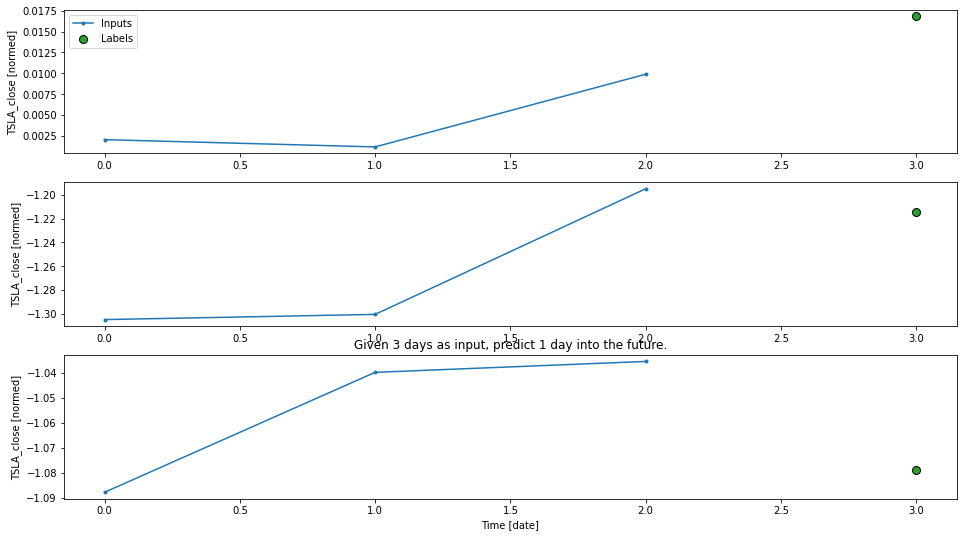

In [37]:
conv_window.plot()
plt.title("Given 3 days as input, predict 1 day into the future.")

You could train a dense model on a multiple-input-step window by adding a layers.Flatten as the first layer of the model

In [38]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [39]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 147)
Output shape: (32, 1, 1)


In [40]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test)

4/4 [==============================] - 0s 751us/step - loss: 140.5192 - mean_absolute_error: 9.9811


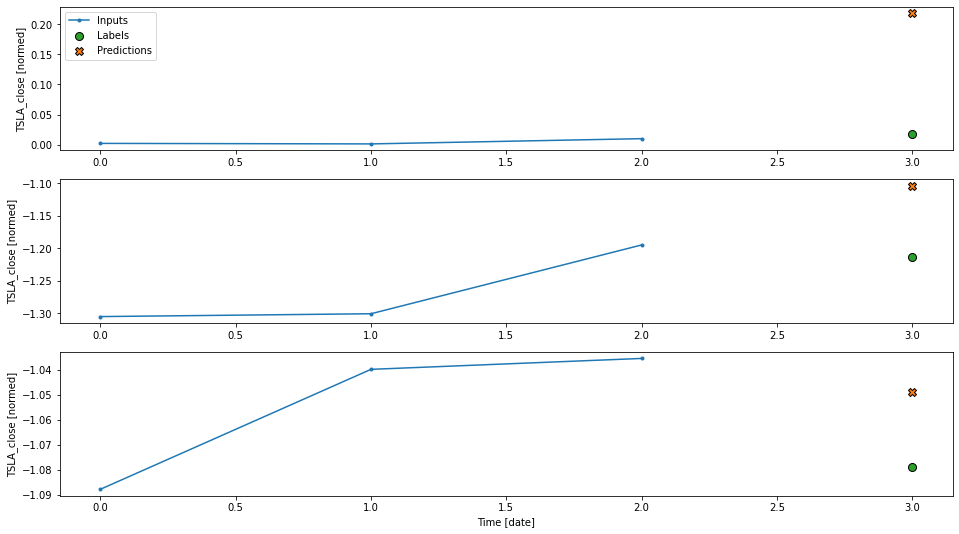

In [41]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input wndows of exactly this shape.

In [42]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 7, 147)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,1029], In[1]: [441,32] [Op:MatMul]


### Convolution neural network

In [43]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [44]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 147)
Output shape: (32, 1, 1)


In [45]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

8/8 [==============================] - 0s 694us/step - loss: 1.5756 - mean_absolute_error: 0.8776


In [46]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 7, 147)
Labels shape: (32, 7, 1)
Output shape: (32, 5, 1)


In [47]:
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=label_columns)

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [3 4 5 6 7 8 9]
Label column name(s): ['TSLA_close']

In [48]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 9, 147)
Labels shape: (32, 7, 1)
Output shape: (32, 7, 1)


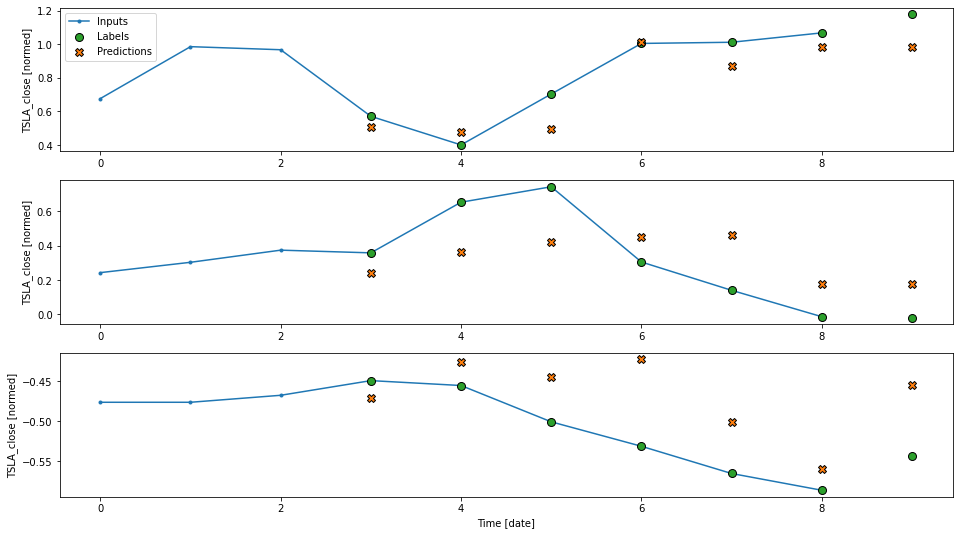

In [49]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

In [50]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [51]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 7, 147)
Output shape: (32, 7, 1)


In [52]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

4/4 [==============================] - 0s 1ms/step - loss: 224.9960 - mean_absolute_error: 12.7552


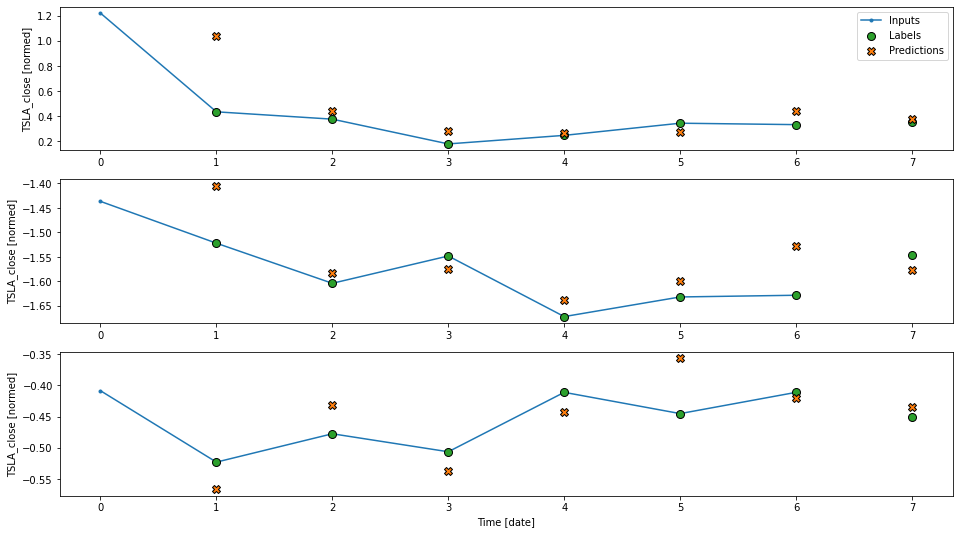

In [53]:
wide_window.plot(lstm_model)

### Performance

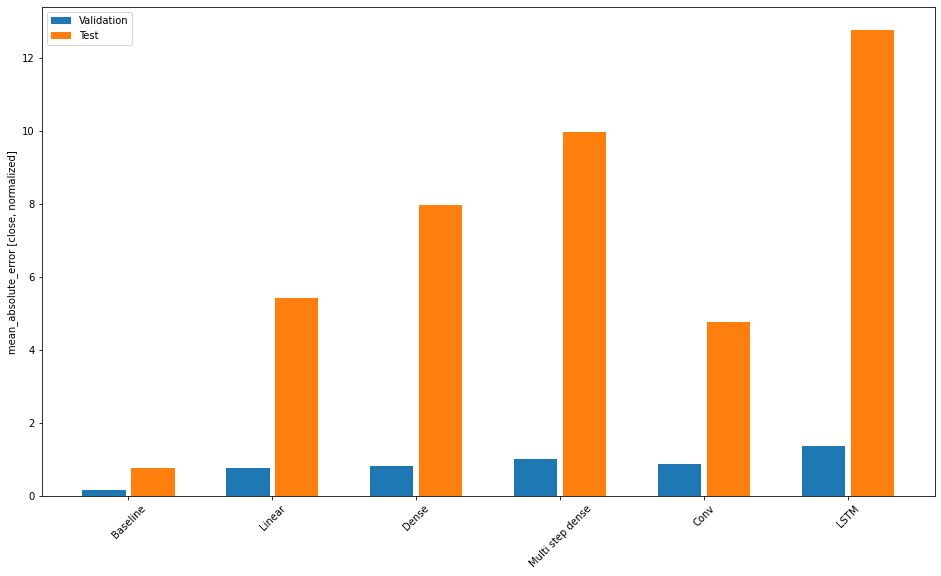

In [54]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [55]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.7712
Linear      : 5.4202
Dense       : 7.9645
Multi step dense: 9.9811
Conv        : 4.7670
LSTM        : 12.7552


### Multi Output Models

In [56]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 147)
Labels shape (batch, time, features): (32, 7, 147)


In [57]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [58]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

8/8 [==============================] - 0s 649us/step - loss: 0.2611 - mean_absolute_error: 0.1905


In [59]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [60]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

4/4 [==============================] - 0s 790us/step - loss: 122.6585 - mean_absolute_error: 3.3088


In [61]:
%%time
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

8/8 [==============================] - 0s 1ms/step - loss: 1.9727 - mean_absolute_error: 0.8872

CPU times: user 18 s, sys: 5.98 s, total: 24 s
Wall time: 10.3 s


In [62]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [63]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

8/8 [==============================] - 0s 1ms/step - loss: 0.2600 - mean_absolute_error: 0.1946

CPU times: user 4.61 s, sys: 1.02 s, total: 5.63 s
Wall time: 3.45 s


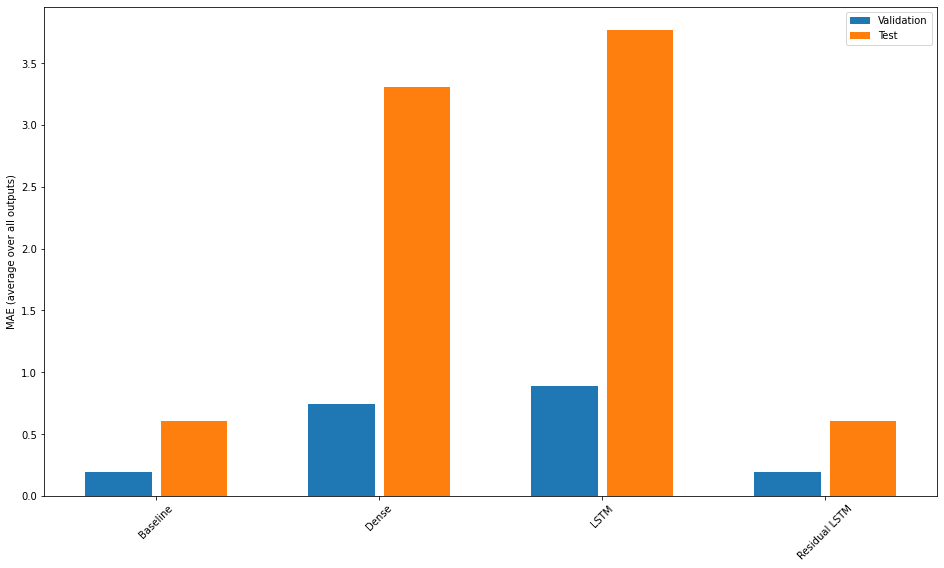

In [64]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

### Multi Step Models

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

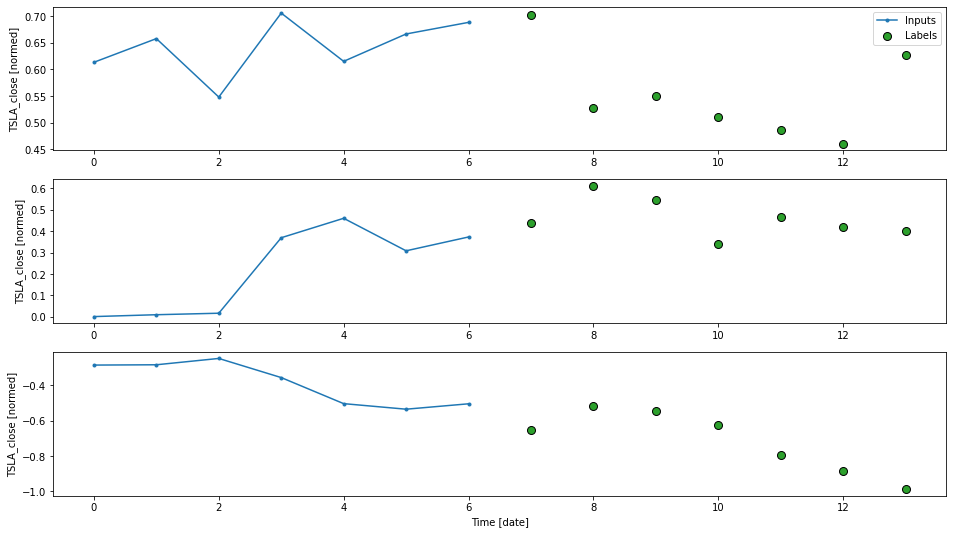

In [65]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

8/8 [==============================] - 0s 658us/step - loss: 0.4876 - mean_absolute_error: 0.2795


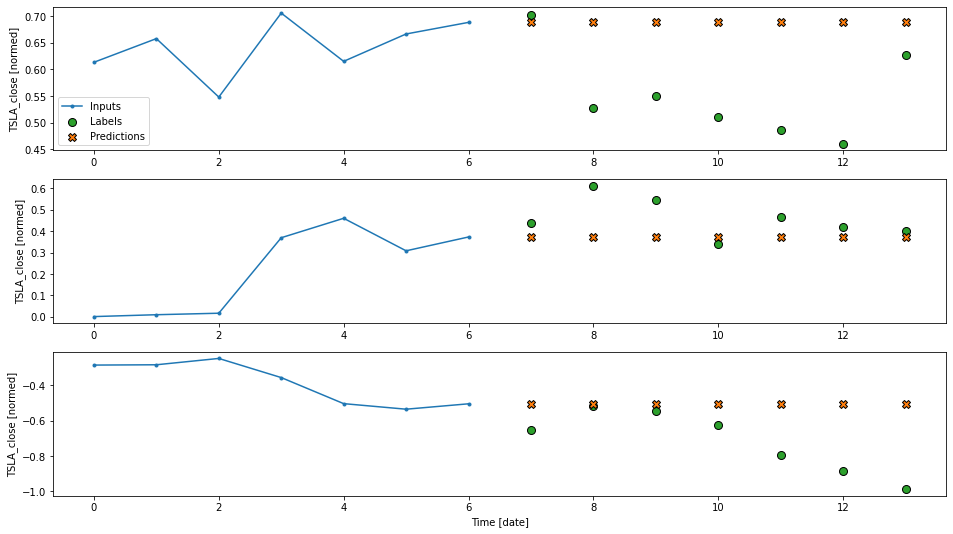

In [66]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

8/8 [==============================] - 0s 734us/step - loss: 0.6628 - mean_absolute_error: 0.3440


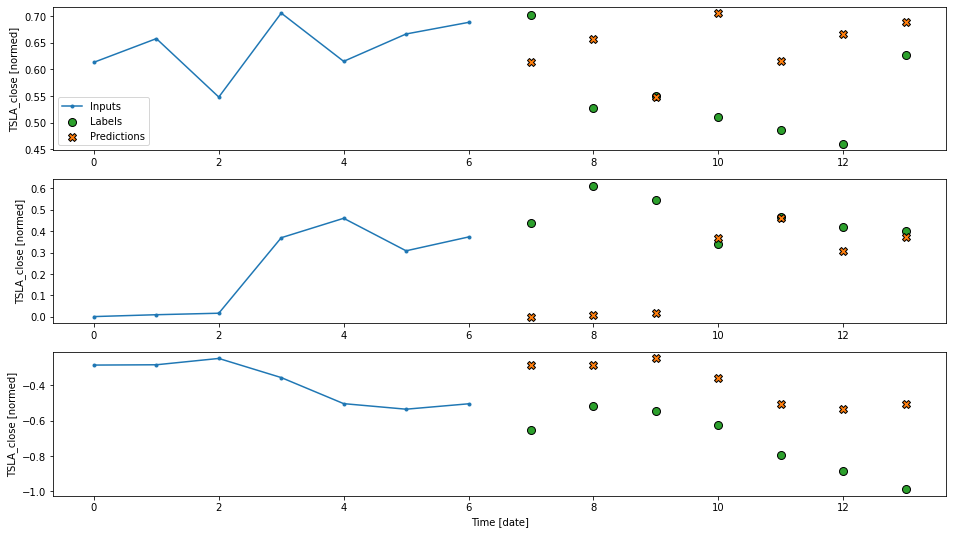

In [67]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

8/8 [==============================] - 0s 798us/step - loss: 0.7776 - mean_absolute_error: 0.4957


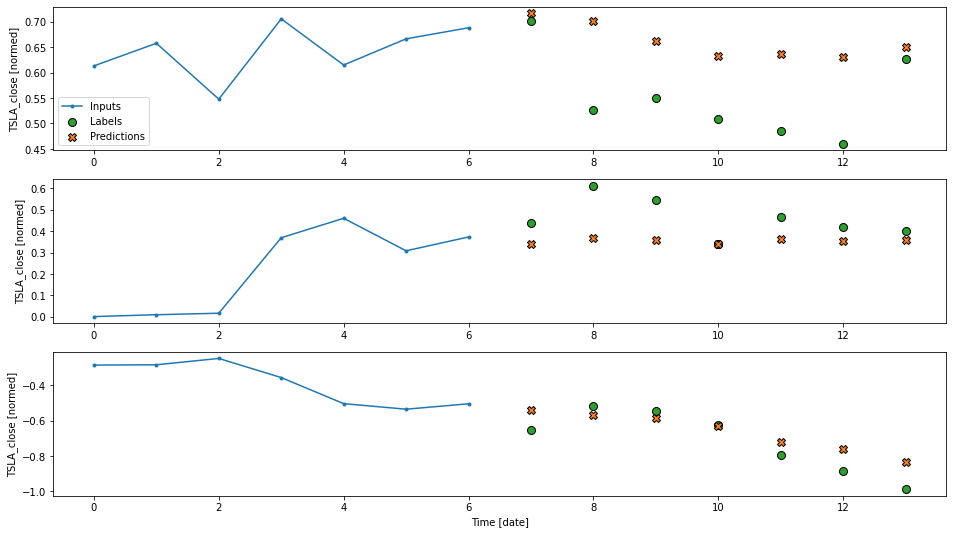

In [68]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

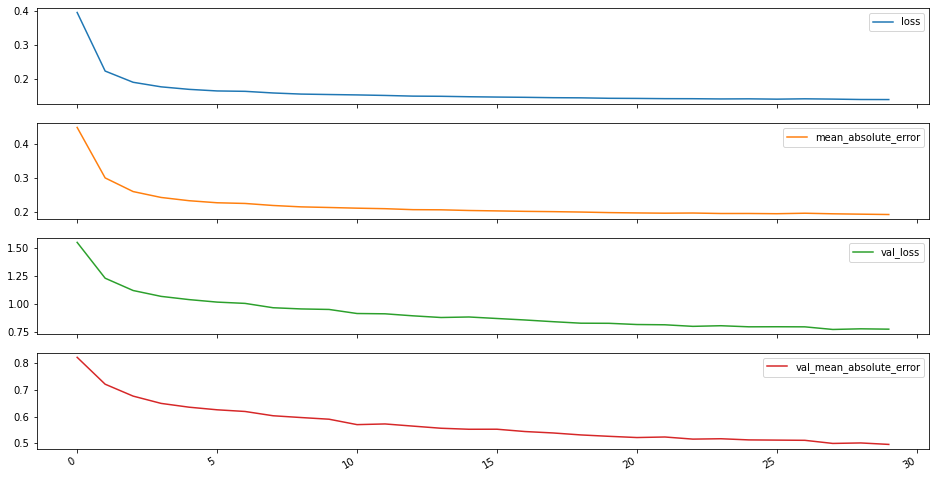

In [69]:
pd.DataFrame(history.history).plot(subplots=True)

### Dense
Adding a layers.Dense between the input and output gives the linear model more power, but is still only based on a single input timestep.

8/8 [==============================] - 0s 1ms/step - loss: 1.2075 - mean_absolute_error: 0.6727


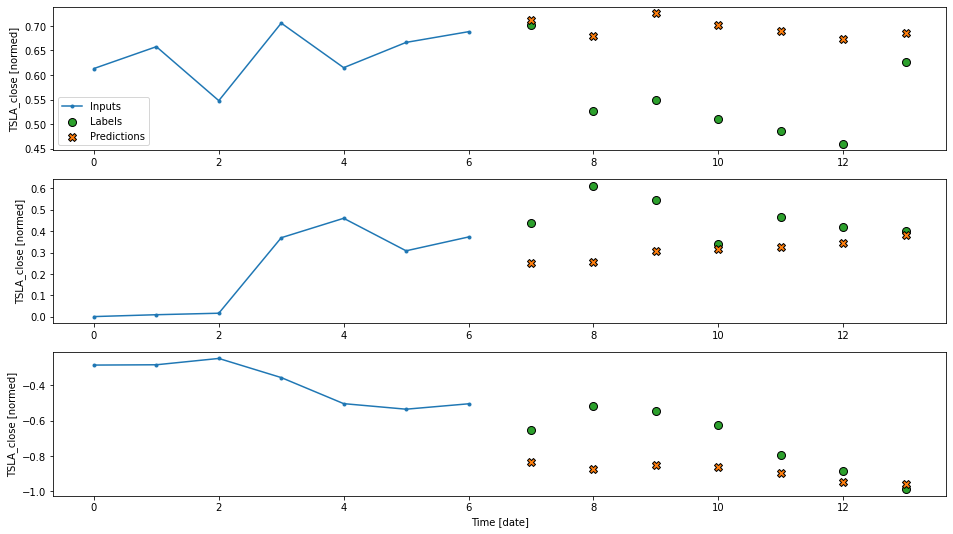

In [70]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

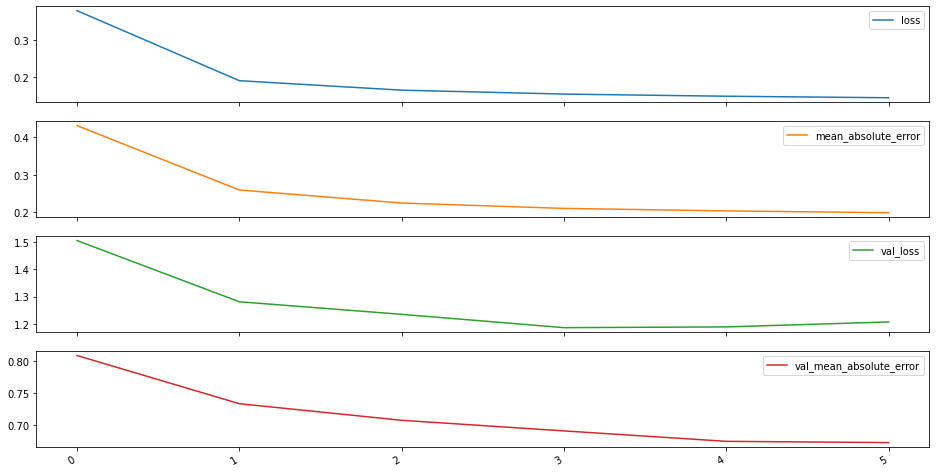

In [71]:
pd.DataFrame(history.history).plot(subplots=True)

### CNN

8/8 [==============================] - 0s 922us/step - loss: 1.3021 - mean_absolute_error: 0.6848


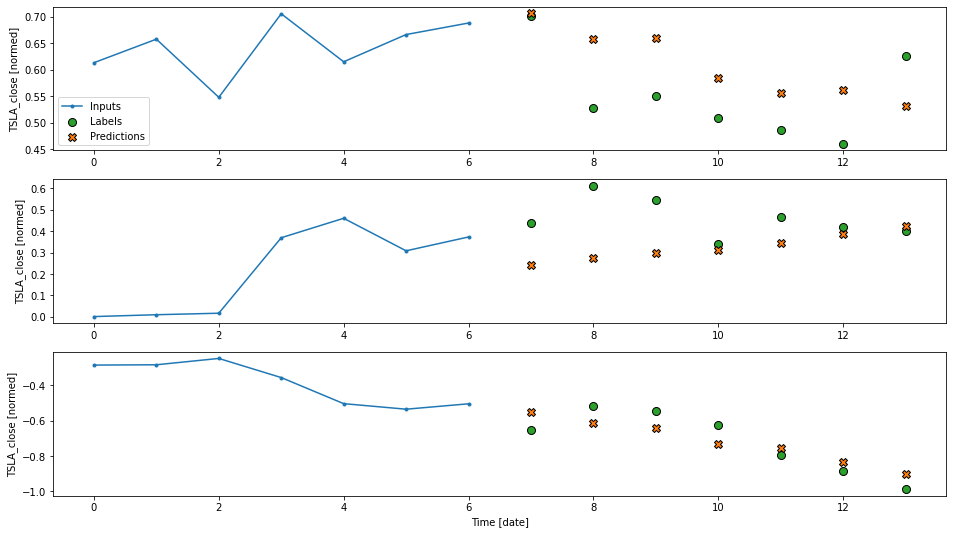

In [72]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

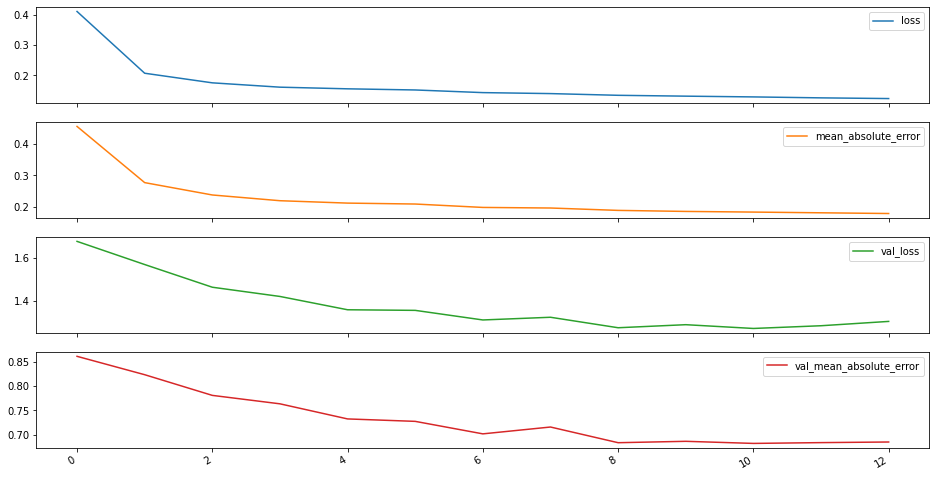

In [73]:
pd.DataFrame(history.history).plot(subplots=True)

### RNN

8/8 [==============================] - 0s 1ms/step - loss: 2.4275 - mean_absolute_error: 1.0531


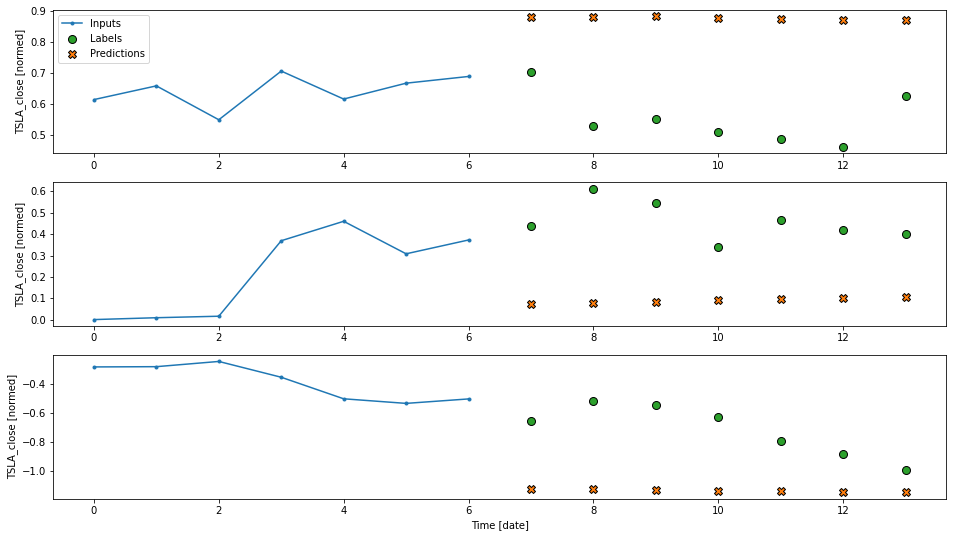

In [74]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_lstm_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

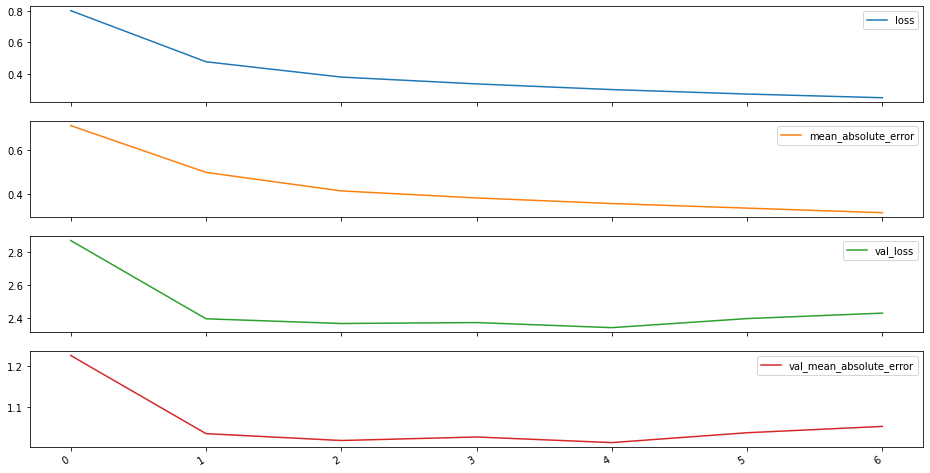

In [75]:
pd.DataFrame(history.history).plot(subplots=True)

### Advanced: Autoregressive model

#### RNN

In [76]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
   
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [77]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [78]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 147])

In [79]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 7, 147)


8/8 [==============================] - 0s 2ms/step - loss: 2.4773 - mean_absolute_error: 1.0762


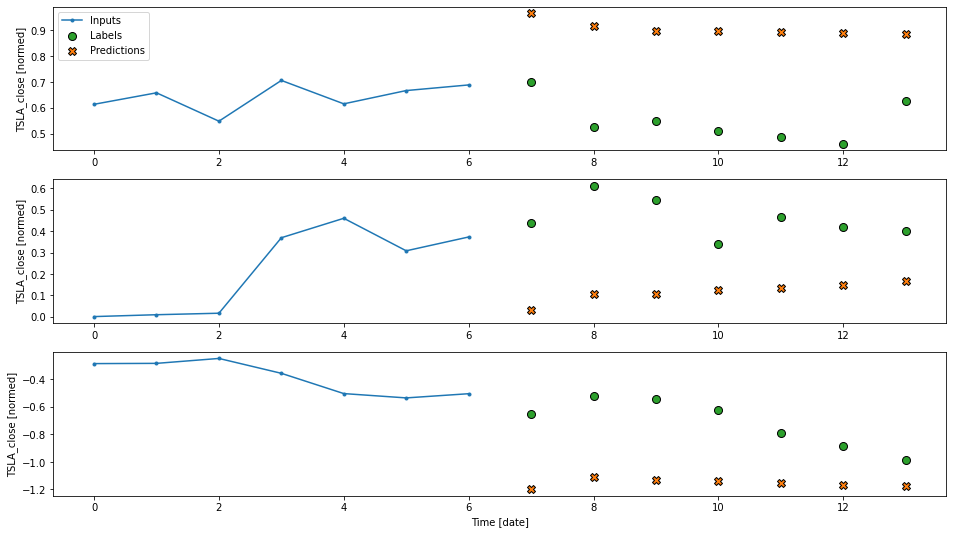

In [80]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

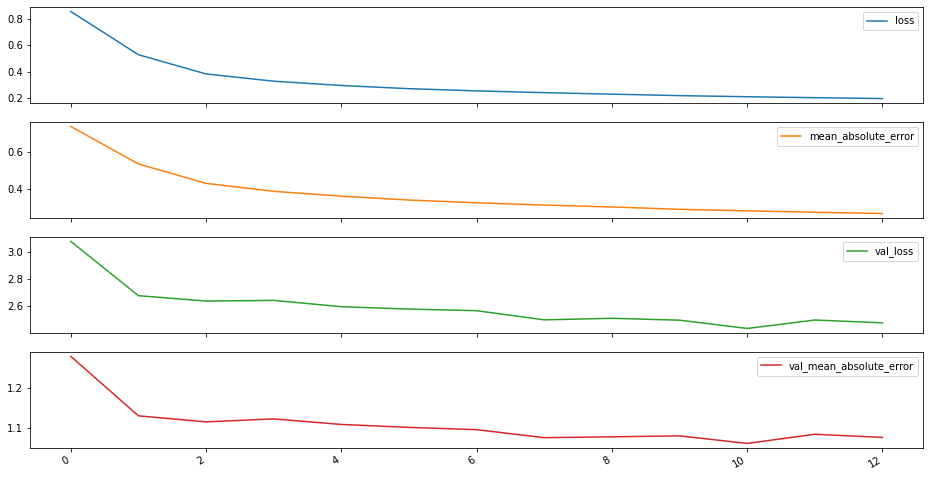

In [81]:
pd.DataFrame(history.history).plot(subplots=True)

### Custom Model

Using a CNN with average pooling and dropout layer in front of stacked Bidirectional LSTM layers.

8/8 [==============================] - 0s 12ms/step - loss: 1.9365 - mean_absolute_error: 0.8764


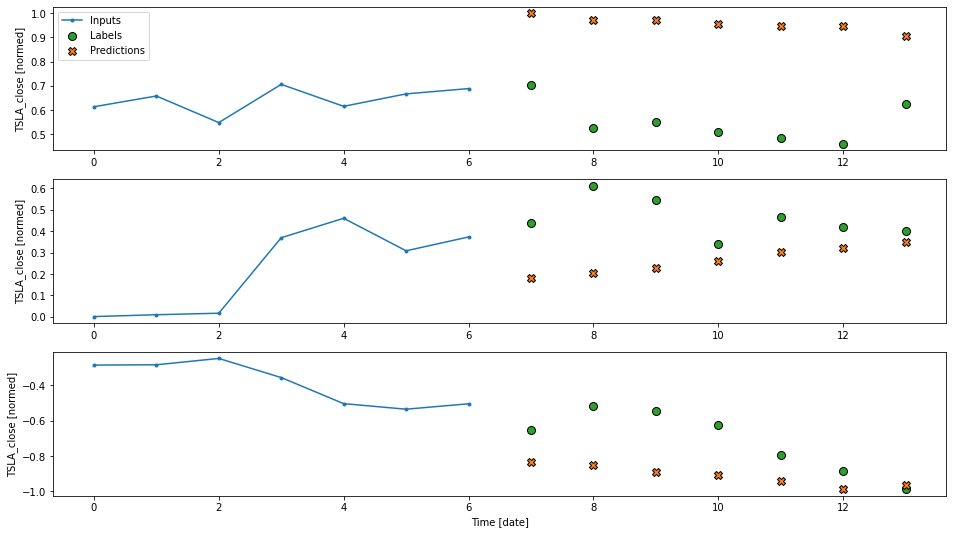

In [239]:
custom_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(512, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.AveragePooling1D(1),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024)),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(custom_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Custom'] = custom_model.evaluate(multi_window.val)
multi_performance['Custom'] = custom_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(custom_model)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

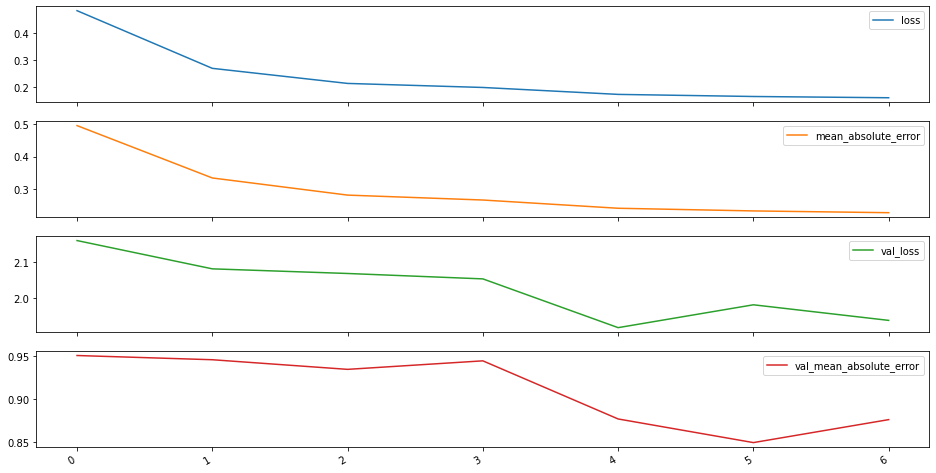

In [240]:
pd.DataFrame(history.history).plot(subplots=True)

### Performance

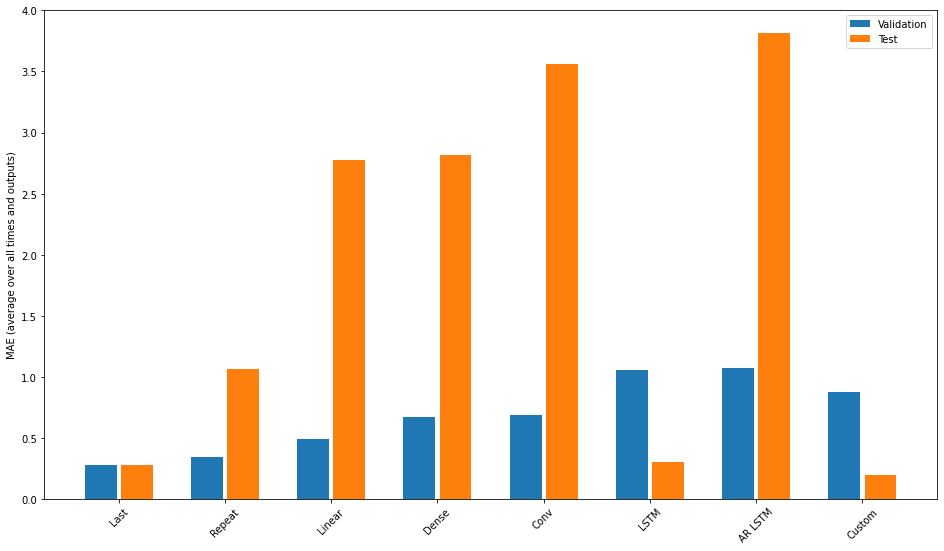

In [241]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [242]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2795
Repeat  : 1.0611
Linear  : 2.7769
Dense   : 2.8183
Conv    : 3.5627
LSTM    : 0.3036
AR LSTM : 3.8128
Custom  : 0.1982


Peeking at some other predictions made by the custom model... it predicts all features!

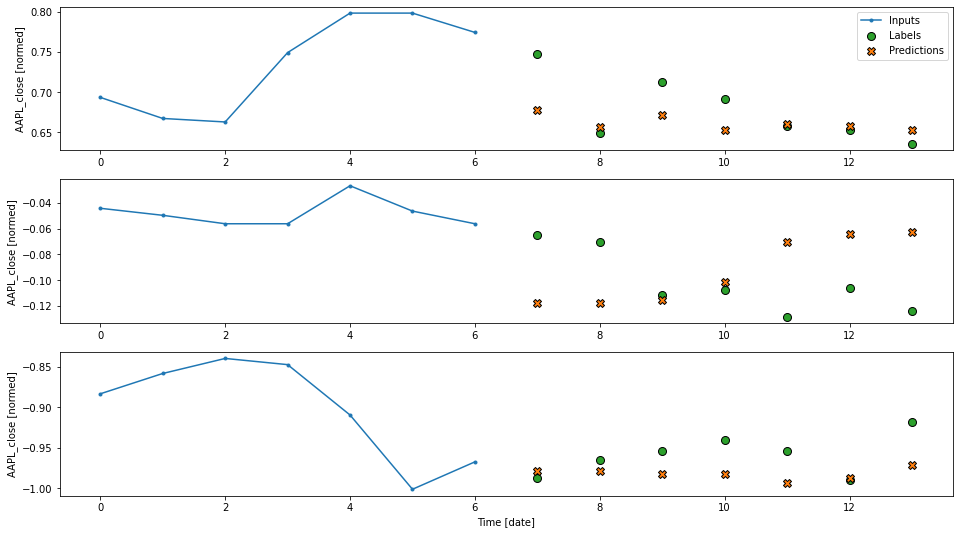

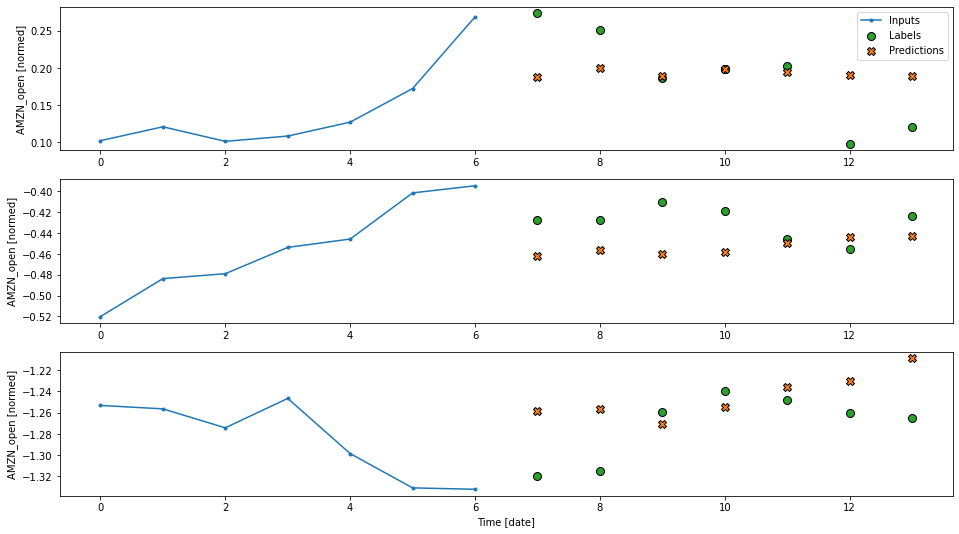

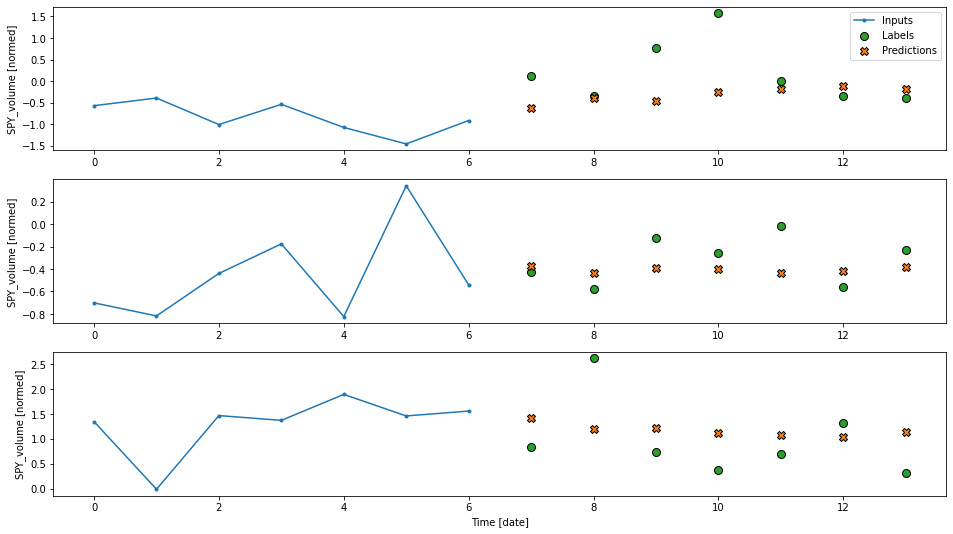

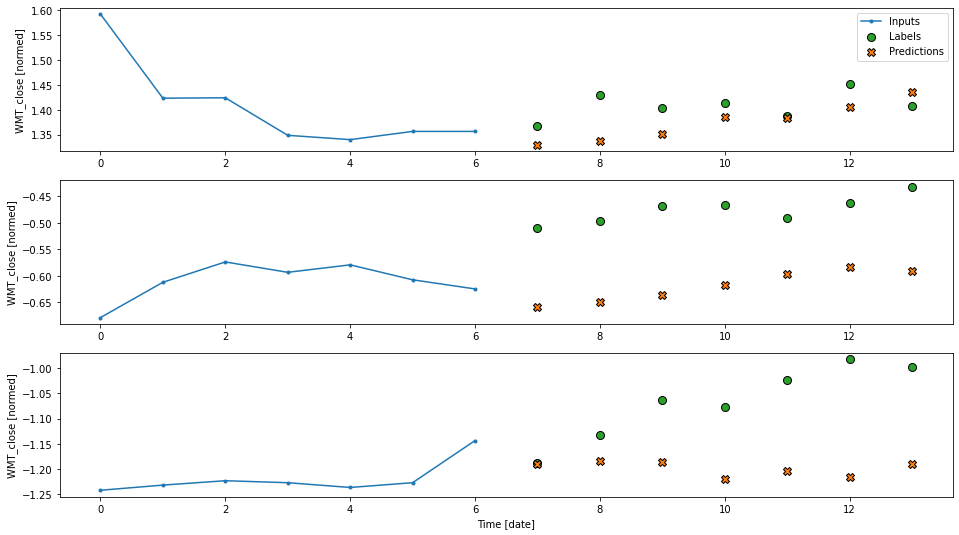

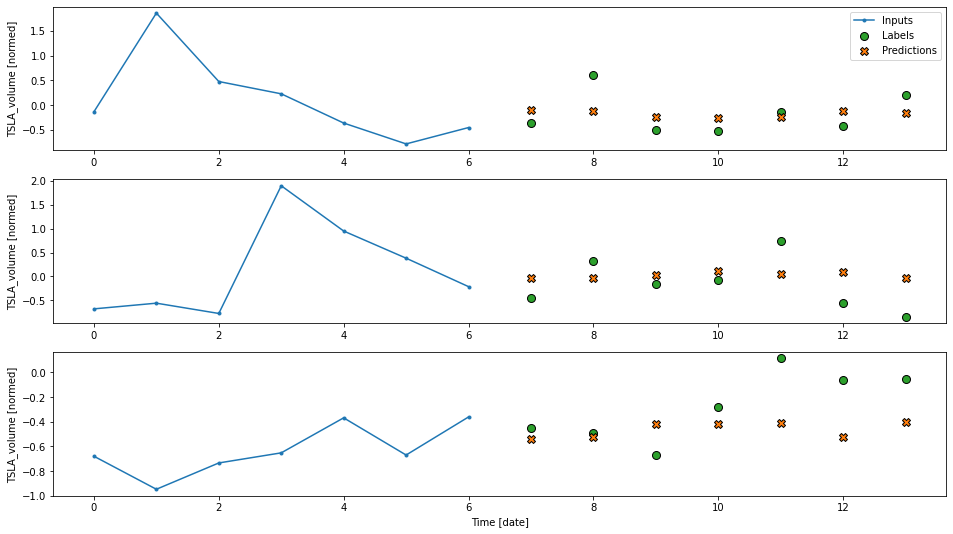

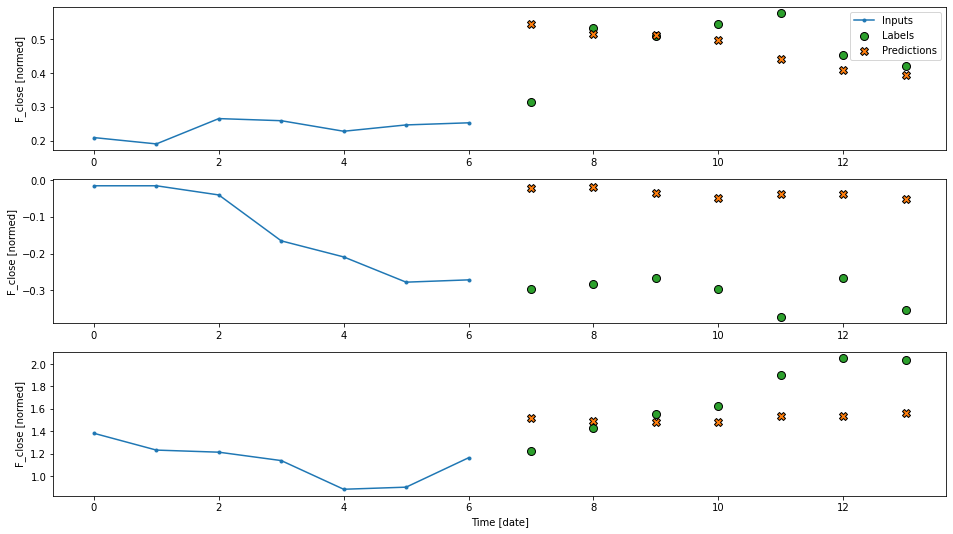

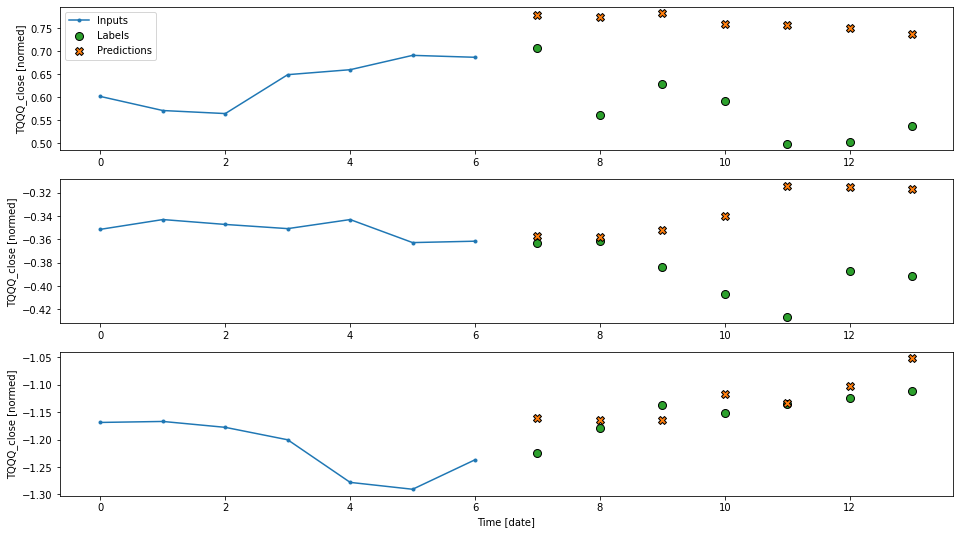

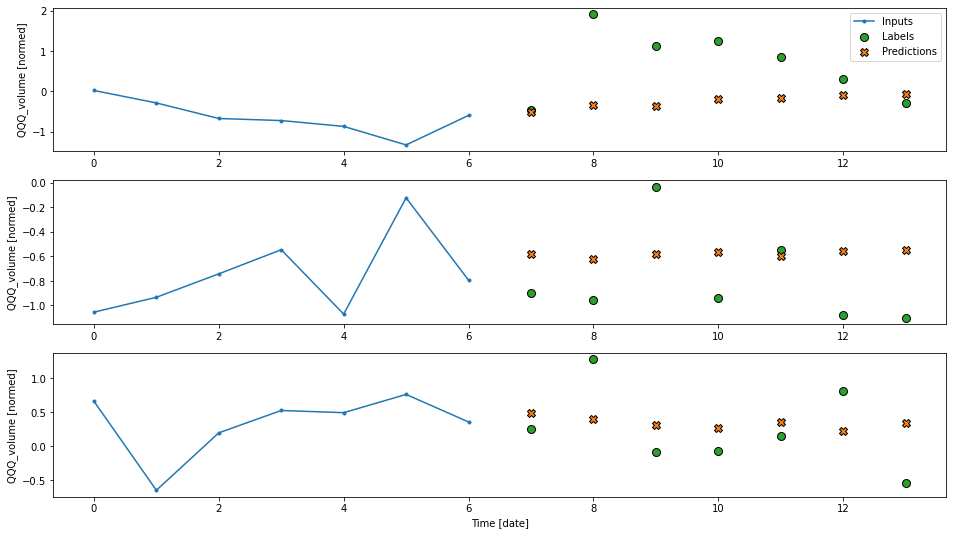

In [243]:
for plot_col in ['AAPL_close', 'AMZN_open', 'SPY_volume', 'WMT_close', 'TSLA_volume', 'F_close', 'TQQQ_close', 'QQQ_volume']:
    multi_window.plot(custom_model, plot_col)